# Introduction to Tests for Categorical Data


### Data Science 410


## Introduction to Tests for Categorical Data

So far, we have been investigating tests for data with continious values. But, many data types are categorical where we work with count statistics. Which hypothesis tests can we apply to these?

## Pearson's Chi-Squared Test

One of the earliest tests for count data was developed by Karl Pearson around 1900. Despite its age, this test is still used today. The Pearson Chi-squared test (also written as $\chi$-squared) has the following properties:

- $\chi$-squared is an unpaired test for counts in different categories.
  * Tests if different categories result in significantly different counts.
  * These categories must be mutually exclusive. For example, does the patient have cancer? (yes/no)
- Examples of test on counts.
  * Rolling a die. Do the six categories, (1,2,3,4,5,6), occur the same frequency (fair die)?
  * Do a group of tweets contain a specific word with unexpectedly high or low frequency?
  * test if the two categories differ in tweet length or word count.
- The Chi-squared statistic depends on the **degrees of freedom** of the test.
  * This is equal to n-1.  Where n equals the number of different categories.
- The test uses the sum of the differences of outcomes from expectations.
- Chi-squared is also used as a **goodness of fit** test. That is to test if sample is representative of population.
  - Test if your sample has expected make up of counts from different categories.
  - For example, if our population has equal numbers of men and women, then we can test if our sample is different from those expected probabilities.

The density of the $\chi$-squared distribution depends on the degrees of freedom, k. The degrees of freedom is computed as k = number of possible outcomes - 1. The $\chi$-squared distribution also depends on the value of the $\chi$-squared statistic.


<img src="img/Chi-square.png" alt="Drawing" style="width:500px; height:350px"/>
<center>Chi-square distribution for different degrees of freedom</center>

As with any probability density function, confidence intervals and p-values can be computed. Notice that the $\chi$-squared distribution becomes flatter and with greater dispersion as the degrees of freedom increase. In practice, this means that you will need large samples to get a meaningful result if you have too many choices in your test. 

## Karl Pearson

Karl Pearson was the dean of late 19th and early 20th century mathematical statisticians. Pearson was a student of Frances Gaulton, the inventor of the regression method. Willam Sealy Gossett was one of Pearsons's students. This realationship is said to be the insparation for Gossett's pseudonym 'Student'. 


<img src="img/Karl_Pearson_1912.jpg" alt="Drawing" style="width:275x; height:350px"/>
<center>Karl Pearson in 1912: A scary looking statistics professor!</center>

In many ways Pearson's influence on the mathematical foundations of statistics is still with us more than a century latter. Many of Pearson's methods are used on a daily basis. Most unfortunately, Pearson was also a eugenicist and a racist. His misuse of statistics in this area has tarnished his legacy.

### Building a Chi-squared table

The traditional way to apply a Chi-squared test is to first create a Chi-squared table. While such tables are not built piece by piece in modern practice, doing so will help you understand the principles involved.     

In this example we are looking the results of an A-B test with three possible outcomes. For example, this type of test might be applied to determine if a new web site drives more customer purchases. 

the code in the cell below builds a simple Chi-squared table. The columns in the data frame are:

- The actual occurrence of events.
- The expected probability of these events. This is the **distribution of the null hypothesis**.
- The expected occurrence of events given the expected probabilities under the null hypothesis.
- The difference between the occurrence and the expected number of events under the null hypothesis.
- The square of the difference.
- The squared difference normalized by the expected number of occurrences. The sum of these figures in the Chi-squared statistic. 

Execute the code and examine the results. 

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.stats.power as ssp
import matplotlib.pyplot as plt
%matplotlib inline


In [21]:
ab_data = pd.DataFrame({'Action':['Leave Page', 'Continue Purchase', 'Add More to Purchase'],
                       'occurrence':[55,43,22],
                       'expected_per':[0.6,0.3,0.1]})
sum_occurrence = ab_data.loc[:, 'occurrence'].sum()
ab_data.loc[:, 'expected_occurance'] = sum_occurrence * ab_data.loc[:, 'expected_per']
ab_data.loc[:, 'diff'] = ab_data.loc[:, 'occurrence'] - ab_data.loc[:, 'expected_occurance'] 
ab_data.loc[:, 'sqr_diff'] = ab_data.loc[:, 'diff'].apply(lambda x: x**2)
ab_data.loc[:, 'diff_expect'] = ab_data.loc[:, 'sqr_diff'].div(ab_data.loc[:, 'expected_occurance'], axis='index')
ab_data = ab_data.append({'Action': 'Totals',
                      'occurrence': sum_occurrence,
                       'expected_per':  [np.nan],
                      'expected_occurance': [np.nan],
                      'diff': [np.nan],
                      'sqr_diff': [np.nan],
                      'diff_expect': ab_data.loc[:, 'diff_expect'].sum()}, 
                        ignore_index =  True)
ab_data = ab_data[['Action', 'occurrence', 'expected_per', 'expected_occurance', 'diff', 'sqr_diff', 'diff_expect']]
ab_data                                       

,Action,occurrence,expected_per,expected_occurance,diff,sqr_diff,diff_expect
0,Leave Page,55,0.6,72,-17,289,4.013889
1,Continue Purchase,43,0.3,36,7,49,1.361111
2,Add More to Purchase,22,0.1,12,10,100,8.333333
3,Totals,120,[nan],[nan],[nan],[nan],13.708333


This Chi-squared table is interpreted as follows:

- The $\chi$-squared test statistic is 13.708, which is computed as the sum of the squared differences normalized by the expected occurrences.
- The $\chi$-squared distribution has (3 Outcomes - 1) = 2 degrees of freedom. Degree of freedom is the number of outcome options (3) minus 1.

We need to compute the p-value given the $\chi$-squared test statistic and the degrees of freedom. The [scipy.stata.chi2.cdf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html) method is used to compute the p-value. Execute the code in the cell below to compute the p-value.

In [17]:
import scipy.stats as ss
1 - ss.chi2.cdf(13.7, df = 2)

0.0010594556929076626

This p-value is rather small. Evidently, there is a small chance that the  differences between the occurrences and expected occurrences are from random variation alone. 

### Computing the Statistics

In the foregoing example we computed the Chi-squared statistic and p-value directly. In general, this is a somewhat cumbersome approach. Instead, we can use the [scipy.stats.chisquare](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html) function to compute these statistics. Execute the code in the cell below and examine the results. 

In [18]:
chisq, pvalue = ss.chisquare(ab_data.loc[:, 'occurrence'][:3], 
             ab_data.loc[:, 'expected_occurance'][:3])
print('Chi Squared statistic = ' + str(chisq))
print('P=value = ' + str(pvalue))

Chi Squared statistic = 13.708333333333334
P=value = 0.0010550504780913119


The difference between the expected and observed number of occurrences is significant. The large Chi-squared value on 2 degrees of freedom and the small p-value indicate we can reject the null hypothesis that the observed occurrences follow the same distribution as the expected occurrences. There is a low chance that the sample arises from the null distribution. 

### Power of the test

Finally, we should check the power of our test. Execute the code in the cell below and examine the results. In this case, we will use the [statsmodels.stats.power.GofChisquarePower().solve_power()](https://www.statsmodels.org/devel/generated/statsmodels.stats.power.GofChisquarePower.power.html#statsmodels.stats.power.GofChisquarePower.power) function to compute power vs. effect size. Execute this code to determine if this test has reasonable power.

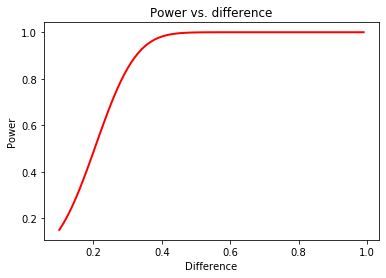

In [22]:
def plot_power(x, y, xlabel, title):
    plt.plot(x, y, color = 'red', linewidth = 2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Power')

diffs = np.arange(start = 0.1, stop = 1.0, step = 0.01) 
powers = ssp.GofChisquarePower().power(effect_size = diffs, nobs=120, n_bins = 3, alpha=0.05)
plot_power(diffs, powers, xlabel = 'Difference', title = 'Power vs. difference') 

Apparently, this test is quite powerful, and we could have detected much smaller differences between the observed and expected counts. 

**Your Turn!** As you have observed, the test is quite powerful with 120 observations. But, what if we do not have a sample this large? Compute and plot the power of the Chi-squared test for an effect size of 1.0 at sample sizes in the range $\{ 10, 100\}$. The nobs argument specifies the sample size. 

Examine your results. At what sample size is the power of the test approximately 1.0? 

## Fisher's Exact Test

The assumptions behind the Chi-squared statistic breakdown when the sample size is small (e.g. number of occurrences $\le 10$). In this case you can use Fisher's Exact Test. In practice Fisher's exact test is rarely used, but it is interesting  to think about it anyway as an example of a **permutation test**. 

According to the story, in 1911 Ronald Fisher worked in the same institution with a talented aquatic botanist, Dr. Muriel Bristol, who was quite particular about how her tea was served. Dr. Bristol told Fisher that she could tell the difference between cups of tea where the milk had been poured into the cup before or after the tea was poured. 

<img src="img/Bristol.png" alt="Drawing" style="width:450px; height:300px"/>
<center>Dr Muriel Bristol, noted aquatic botanist, and quite particular about her tea.

Fisher, was a bit skeptical. He challenged Dr. Bristol to a test. In this test, Fisher prepared eight cups of tea. Four of the cups of where prepared in Dr. Bristol's preferred manner and the other four the other way. The tea was prepare out of sight of Dr. Bristol. However, she knew that there were four cups prepared each way. The order of presentation of each cup of tea was randomized. Fisher served the cups of tea to Dr. Bristol and asked her how the tea had been poured. In every case, she was correct!

Fisher devised a **permutation test** to determine the likelihood that Dr Bristol could have simply guessed the correct outcome. He devised the following permutation table for the chances of success:

<img src="img/tea.png" alt="Drawing" style="width:700px; height:300px"/>

The possible permutations of the ways that Dr Bristol could have correctly (success) or incorrectly (failure) identified the way each cup of tea was prepared is 8 choose 4:

$$\binom{8}{4} = \frac{8!}{4!(8-4)!} = 70$$

So, the chance that the Dr Bristol could purely guess (by random chance) the outcome is only 1 in 70 or about 1.4%. 

### Example of Fisher's Exact Test

As has already been stated, Fisher's exact test is a **small sample test**. Such tests are of limited importance in the 21st Century. There are still some cases where we must work with small samples. An example is with scientific data where collection of more data is expensive or simply infeasible.     

Let's try an example of Fisher's exact test. Take a simple 2X2 matrix of counts. The counts are number of success and failures for two samples (two sets of Bernoulli trails), on the number of sharks and whales observed in two oceans over some period of time. The null distribution in this cases is that the proportion of sharks to whales is constant between the two oceans. This is a case where the observations are inherently limited and Fisher's exact test can be used.   

The code in the cell below using the [scipy.stats.fisher_exact](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html) function to compute a Fisher exact test. Run the code and examine the results.  

In [20]:
mat_test = pd.DataFrame(np.array([[8,2],[1,5]]),
                       index = ['wales', 'sharks'],
                       columns = ['Atlantic', 'Indian'])
print(mat_test)
oddsratio, pvalue = ss.fisher_exact(mat_test)
print('\nOddsratio = ' + str(oddsratio))
print('P-value = ' + str(pvalue))

        Atlantic  Indian
wales          8       2
sharks         1       5

Oddsratio = 20.0
P-value = 0.03496503496503495


In this case, we can reject the null hypothesis. Evidently the difference of counts of wales and sharks in the two oceans from this experiment is unlikely to arise from the null distribution. 

## Summary

We have covered lot of ground in this lesson. Specifically we have discussed:

- The $\chi$-squared test for count data. The null hypothesis is that there is no significant differences in the counts and the samples are from the same population. 
- Power of tests on counts. The power of a test is the probability of getting a positive result when the null hypothesis is not true. 
- Fisher's exact test is a permutation test suitable for small count samples. 

#### Copyright 2019, 2020, Stephen F Elston. All rights reserved.